# Matching an Experimental image to an existing vPCFs library

The procedure to create the library is described in the "Nanoscale phase identification_vPCFs" noteboook. If you have not created a database and need to create a different database to the one provided please follow the procedure described there. In this notebook, we will:

1. Load an experiemtnal image.
2. Create the experimental vPCF, the experimental vPCF should maitain the same pixel size as the ones created in the library (pixel_sizel = 2 pm).
3. Load the vPCFs library.
4. Match the experimental image to the library. 


Lets define some useful funtions:

In [39]:
from vpcffit.utils import xy_to_rt
import numpy as np
from joblib import Parallel, delayed
from vpcffit.vpcffit import near_neighbor_distance, crop_at_position
import plotly.graph_objects as go
from scipy.ndimage import rotate
import hyperspy.api as hs
import atomap.api as am
from scipy.optimize import minimize

def compare_exp_plot(match_DB,
                     target,
                     keys,
                     sigma_threshold = 3,
                     save = False,
                     file= None,
                     mark_size = 6
                     ):
    tree_values= match_DB[0]
    rotation = match_DB[1]
    bs = match_DB[2]
    sigma = match_DB[3]
    best_match_itree = np.argmin(tree_values)
    best_scale_match = bs[best_match_itree]
    best_rotation =  rotation[best_match_itree]
    best_match_pc = np.array(library_pcs[best_match_itree]) 
    
    sorted_tree_values, sorted_keys, sorted_sigma, sorted_bs, sorted_rotation = zip(*sorted(zip(tree_values, keys, sigma, bs, rotation)))
    
    # Compare the arrays to see differences
    differences = np.abs(np.array(sorted_tree_values) - sorted_tree_values[0])
    combined_sigma = np.sqrt((sigma_threshold * np.array(sigma))**2 + (sigma_threshold * np.array(sorted_sigma[0]))**2)
    within_sigma = differences <= combined_sigma
    matches = np.where(within_sigma)[0]
    colorbar = ['#1f77b4'] * len(keys)
    best_match_tree = []
    for index in matches:
        colorbar[index] = 'pink'
        best_match_tree.append(sorted_keys[index])
    
    #plot
    bar1 = go.Bar(
        x=sorted_keys,
        y=sorted_tree_values,
        marker_color = colorbar,
        text=[f"{num:.2f}   " for num in sorted_bs],  # Text on top of each bar
        textposition='outside',  # Position text above bars
        textangle=90,
        error_y = dict(
                type='data',  # Type of error, can also be 'percent' or 'constant'
                array=sigma,  # Error values for each bar
                #visible=True  # Display the error bars
        ),
        hovertemplate=(
                '<b>Category:</b> %{x}<br>'  # Displays the x value (Category)
                '<b>Value:</b> %{y}<br>'     # Displays the y value
                '<b>scale:</b> %{text}'  # Displays the error value
                '<extra></extra>'  # Removes the default trace name
                )
        )
   
    # vPCF initially showing Experimental data
    vPCF1 = go.Scatterpolar(theta=np.mod(xy_to_rt(target)[:,1] + best_rotation,2*np.pi)*180/np.pi,
                            r=xy_to_rt(target)[:,0]*best_scale_match,
                            mode='markers', 
                            name='Experimental<br>vPCFs',
                            marker=dict(color='blue', size=mark_size))
    
    # vPCF initially showing best match
    vPCF2 = go.Scatterpolar(theta=xy_to_rt(best_match_pc)[:,1]*180/np.pi,
                            r=xy_to_rt(best_match_pc)[:,0],
                            mode='markers',
                            name="Best Matches<br>" + str(best_match_tree),
                            marker = dict(color='red', size=mark_size-int(mark_size/2)))
    
    fig = go.FigureWidget(data=[bar1])
    fig3 = go.FigureWidget(data=[vPCF1, vPCF2])

    
    # Customize layout
    fig.update_layout(
            height=400, width=800,
            showlegend=False,
            title = "Average Near Neighbor Distance",
            xaxis=dict(tickangle=90),  # Rotate x-axis labels
            xaxis2=dict(tickangle=90),
            hovermode="closest",
            legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="left",
                    x=0
                    )
            )
    fig3.update_layout(height=400, width=400,
                       legend=dict(
                               orientation="h",
                               yanchor="bottom",
                               y=1.02,
                               xanchor="left",
                               x=0
                               ),
                       polar=dict(radialaxis=dict(range=[0, limit],
                                                  showline=False,  # Show the radial axis lines
                                                  linewidth=1.5,    # Set the width of the radial axis lines
                                                  linecolor="black",  # Set the color of the radial axis lines
                                                  showticklabels=False,
                                                  showgrid=True,  # Turn on the radial grid
                                                  gridcolor="grey",  # Color of the radial grid
                                                  griddash="dot",  # Style of the radial grid (solid, dot, dash)
                                                  gridwidth=1  # Thickness of the grid line
                                                  ),
                                  angularaxis=dict(
                                          showline=True,  # Show the radial axis lines
                                          linewidth=1.5,    # Set the width of the radial axis lines
                                          linecolor="black"  # Set the color of the radial axis lines
                                          ),
                                  bgcolor="rgba(0,0,0,0)",# Transparent background for polar plot area
                       ))
    
    def onclick_fn(trace, points, state):
        inds = np.array(points.point_inds)
        if inds.size:
            vPCFs2.name = str(points.xs)
            index = keys.index(vPCFs2.name[2:-2])
            vPCFs1.r = xy_to_rt(target)[:,0]*bs[index]
            vPCFs1.theta = np.mod(xy_to_rt(target)[:,1]+rotation[index],2*np.pi)*180/np.pi
            vPCFs2.r = xy_to_rt(library_pcs[index])[:,0]
            vPCFs2.theta = xy_to_rt(library_pcs[index])[:,1]*180/np.pi
    
    bar1 = fig.data[0]
    vPCFs1 = fig3.data[0]
    vPCFs2 = fig3.data[1]
    bar1.on_click(onclick_fn)
    
    # ipywidgets
    from ipywidgets import HBox, VBox, Button
    if save:
        fig.write_html(file+"_bar_plot.html")
        fig3.write_html(file+"_vPCFs.html")
    display(HBox([fig,fig3]))
    plt.show()
    return best_match_tree
    
def compare_exp_library_plot(match_DB, target, keys, virtual_dic, atomic_models,exp_img, pixel_size, sigma = 3, save = False, file= None, model = 'Powell', mark_size=5):
    tree_values= match_DB[0]
    rotation = match_DB[1]
    bs = match_DB[2]
    sigma = match_DB[3]
    best_match_itree = np.argmin(tree_values)
    best_scale_match = bs[best_match_itree]
    best_rotation =  rotation[best_match_itree]
    best_match_pc = np.array(library_pcs[best_match_itree]) 
    
    sorted_tree_values, sorted_keys, sorted_sigma, sorted_bs, sorted_rotation = zip(*sorted(zip(tree_values, keys, sigma, bs, rotation)))
    
    #compare the arrays to see differences
    differences = np.abs(np.array(sorted_tree_values) - sorted_tree_values[0])
    combined_sigma = np.sqrt((sigma*np.array(sigma))**2 + (sigma*np.array(sorted_sigma[0]))**2)
    within_sigma = differences <= combined_sigma
    matches = np.where(within_sigma)[0]
    colorbar = ['#1f77b4'] * len(keys)
    best_match_tree = []
    for index in matches:
        colorbar[index] = 'pink'
        best_match_tree.append(sorted_keys[index])
    
    size_exp=min(exp_img.shape)
    exp_img=exp_img[0:size_exp,0:size_exp]
    # select and crop STEM images
    def images_com (rot, index):
        rotated_image = rotate(exp_img,-rot*180/np.pi, reshape=False)
        crop_size = int(min(exp_img.shape[0], exp_img.shape[1]) / np.sqrt(2))
        virtual_pixel = virtual_dic[keys[index]][1]
        virtual_size = int(crop_size*pixel_size/virtual_pixel)
        virtual = virtual_dic[keys[index]][0]
        size_virtual=min(virtual.shape)
        virtual=virtual[0:size_virtual,0:size_virtual]
        
        if virtual.shape[0] < virtual_size:
            crop_2 = int(virtual.shape[0]*virtual_pixel/pixel_size)
            rotated_image = crop_at_position(rotated_image,crop_2, crop_2, rotated_image.shape[0]//2,rotated_image.shape[1]//2)
        else:
            rotated_image = crop_at_position(rotated_image,crop_size, crop_size, rotated_image.shape[0]//2,rotated_image.shape[1]//2)
            virtual = crop_at_position(virtual,virtual_size, virtual_size, virtual.shape[0]//2,virtual.shape[1]//2)    
        model_over = atomic_models[keys[index]]
        unique_species = sorted(set(model_over.get_chemical_symbols()))
        coord_DB = {}
        for atom in unique_species:
                coord_DB[atom] = np.array([model_over.positions[i]
                                           for i, condition in enumerate(model_over.get_chemical_symbols())
                                           if condition==atom])[:,0:2]
                coord_DB[atom] = coord_DB[atom][(coord_DB[atom][:,1]/virtual_pixel) < virtual_size//3] / virtual_pixel
                coord_DB[atom] = coord_DB[atom][coord_DB[atom][:,0] < virtual_size//3]
        
        img = hs.signals.Signal2D(virtual)
        image_fit = am.get_atom_positions(img, pca=False, separation=7)
        sublattices = am.Sublattice(image_fit, image=img.data, fix_negative_values=True)
        points = sublattices.atom_positions[:, [1, 0]]
        
        def objective(translation, points1, points2):
            dx, dy = translation  # Translation in x and y
            translated_points1 = points1 + np.array([dx, dy])
            distances = np.linalg.norm(translated_points1[:, None] - points2, axis=2)
            return np.sum(np.min(distances, axis=1))  # Sum of distances to nearest neighbors
        # Minimize the objective function
        result = minimize(objective, np.array([0, 0]), args=(points, coord_DB['Hf']), method=model)
        for key in coord_DB:
            coord_DB[key] -= result.x
        return rotated_image, virtual,virtual_size, coord_DB
    
    rotated_image, virtual, virtual_size,coord_DB = images_com (best_rotation, best_match_itree)
    #plot
    bar1 = go.Bar(
        x=sorted_keys,
        y=sorted_tree_values,
        marker_color = colorbar,
        text=[f"{num:.2f}   " for num in sorted_bs],         # Text on top of each bar
        textposition='outside',  # Position text above bars
        textangle=90,
        error_y = dict(
            type='data',           # Type of error, can also be 'percent' or 'constant'
            array=sigma,    # Error values for each bar
            #visible=True           # Display the error bars
        ),
        hovertemplate=(
                    '<b>Category:</b> %{x}<br>'  # Displays the x value (Category)
                    '<b>Value:</b> %{y}<br>'     # Displays the y value
                    '<b>scale:</b> %{text}'  # Displays the error value
                    '<extra></extra>'  # Removes the default trace name
                )
        )
    #Plot the Virtual image from the dictionary provided initially showing best match
    virtual = go.Heatmap(
    z=-virtual,
    colorscale="Greys",
    showscale=False
    )
    #Plot all sublattices from the model initially showing best match
    fig4 = go.FigureWidget()
    # Loop through the data to add scatter plots for each group
    for key in coord_DB:
        fig4.add_trace(go.Scatter(
            x=coord_DB[key][:,1],
            y=coord_DB[key][:,0],
            mode='markers',  # Use 'markers+lines' for both
            name=key,  # Legend entry
            marker=dict(
            size=5  # Set marker size
            )
        ))
    #Plot experimental STEM image
    experiment = go.Heatmap(
    z=-rotated_image,
    colorscale="Greys",
    showscale=False
    )
    
    # vPCF initially showing Experimental data
    vPCF1 = go.Scatterpolar(theta=np.mod(xy_to_rt(target)[:,1] + best_rotation,2*np.pi)*180/np.pi,
                            r=xy_to_rt(target)[:,0]*best_scale_match,
                            mode='markers', 
                            name='Experimental<br>vPCFs',
                            marker=dict(color='blue', size=mark_size))
    
    # vPCF initially showing best match
    vPCF2 = go.Scatterpolar(theta=xy_to_rt(best_match_pc)[:,1]*180/np.pi,
                            r=xy_to_rt(best_match_pc)[:,0],
                            mode='markers',
                            name="Best Matches<br>" + str(best_match_tree),
                            marker = dict(color='red', size=mark_size-int(mark_size/2)))
    
    fig = go.FigureWidget(data=[bar1])
    fig1 = go.FigureWidget(data=[virtual])
    fig2 = go.FigureWidget(data=[experiment])
    fig3 = go.FigureWidget(data=[vPCF1, vPCF2])
    for trace in fig4.data:
        fig1.add_trace(trace)
    
    # Customize layout
    fig.update_layout(
        height=400, width=800,
        showlegend=False,
        title = "Average Near Neighbor Distance",
        xaxis=dict(tickangle=90),  # Rotate x-axis labels
        xaxis2=dict(tickangle=90),
        hovermode="closest",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="left",
            x=0
        )
    )
    fig1.update_layout(
        height=400, width=400,
        title = "Simulated Image",
        xaxis=dict(
        #range=[0, virtual_size],
        tickvals=[],  # No ticks
        ticktext=[]   # No tick labels
        ),
        yaxis=dict(
        #range=[0, virtual_size],
        tickvals=[],
        ticktext=[]
        ),
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
        )
    )
    fig2.update_layout(
        height=400, width=400,
        title = "Experimental image",
        xaxis=dict(
        tickvals=[],  # No ticks
        ticktext=[]   # No tick labels
    ),
    yaxis=dict(
        tickvals=[],
        ticktext=[]
    )
    )
    
    fig3.update_layout(height=400, width=400,
                       legend=dict(
                                    orientation="h",
                                    yanchor="bottom",
                                    y=1.02,
                                    xanchor="left",
                                    x=0
                                    ),
                        polar=dict(radialaxis=dict(range=[0, limit],
                              showline=False,  # Show the radial axis lines
                              linewidth=1.5,    # Set the width of the radial axis lines
                              linecolor="black",  # Set the color of the radial axis lines
                              showticklabels=False,
                              showgrid=True,  # Turn on the radial grid
                              gridcolor="grey",  # Color of the radial grid
                              griddash="dot",  # Style of the radial grid (solid, dot, dash)
                              gridwidth=1  # Thickness of the grid line
                              ),
                              angularaxis=dict(
                                      showline=True,  # Show the radial axis lines
                                      linewidth=1.5,    # Set the width of the radial axis lines
                                      linecolor="black"  # Set the color of the radial axis lines
                                      ),
                              bgcolor="rgba(0,0,0,0)",# Transparent background for polar plot area
                                      ),
    )
    
    def onclick_fn(trace, points, state):
        inds = np.array(points.point_inds)
        if inds.size:
            vPCFs2.name = str(points.xs)
            index = keys.index(vPCFs2.name[2:-2])
            vPCFs1.r = xy_to_rt(target)[:,0]*bs[index]
            vPCFs1.theta = np.mod(xy_to_rt(target)[:,1]+rotation[index],2*np.pi)*180/np.pi
            vPCFs2.r = xy_to_rt(library_pcs[index])[:,0]
            vPCFs2.theta = xy_to_rt(library_pcs[index])[:,1]*180/np.pi
            rotated_image, virtual, virtual_size, coord_DB = images_com (rotation[index], index)
            vir.z = - virtual
            exp.z = - rotated_image
            for i, key in enumerate(coord_DB):
                fig1.data[i+1].x = coord_DB[key][:,1]
                fig1.data[i+1].y = coord_DB[key][:,0]
    
    bar1 = fig.data[0]
    vir = fig1.data[0]
    exp = fig2.data[0]
    vPCFs1 = fig3.data[0]
    vPCFs2 = fig3.data[1]
    bar1.on_click(onclick_fn)
    
    # ipywidgets
    from ipywidgets import HBox, VBox, Button
    if save:
        fig.write_html(file+"_bar_plot.html")
        fig3.write_html(file+"_vPCFs.html")
        fig1.write_html(file+"_MODEL.html")
        fig2.write_html(file+"_EXP.html")
    display(HBox([VBox([HBox([fig1, fig2]),fig]),fig3]))
    return best_match_tree

def split_at_x_underscore(s, x = 2):
    # Split the string at underscores, with a maximum of 2 splits
    parts = s.split('_', x)

    # Check if there are at least three parts after splitting
    if len(parts) > x:
        first_part = '_'.join(parts[:x])
        second_part = parts[x]
        return first_part, second_part
    else:
        return s, ''
        
def parallel_processing(bounds, target, pc, r_limit, nnd = 'ANND', mask_size = 10, **kwargs):
    bf_tree = []
    bf_scale = []

    # Function to process items in parallel
    def process_item(sc):
        return (near_neighbor_distance(target, pc, 
                                       nnd=nnd, 
                                       r_limit = r_limit,
                                       scale = sc/1000,
                                       mask_size = mask_size, **kwargs)[1],sc / 1000)

    # Parallel processing with joblib
    results = Parallel(n_jobs=-1)(delayed(process_item)(sc) for sc in range(bounds[0], bounds[1] + bounds[2], bounds[2]))

    # Split results into bf_tree and bf_scale
    for result, scale in results:
        bf_tree.append(result)
        bf_scale.append(scale)

    return bf_tree, bf_scale


# Function to handle each item in list_of_pcs
def parallel_process_pc(pc, target, bounds, r_limit, nnd = 'ANND', mask_size = 10, **kwargs):
    # Perform parallel processing on bf_tree and bf_scale
    bf_tree, bf_scale = parallel_processing(bounds, target, pc, r_limit, nnd)

    # Find best scale and compute ANN
    best_tree = np.argmin(bf_tree)
    best_scale = bf_scale[best_tree]


    # Calculate the rotation and align the two point clouds
    ANN = near_neighbor_distance(target, pc,
                                 nnd=nnd,
                                 r_limit = r_limit,
                                 scale = best_scale,
                                 mask_size = 10,
                                 **kwargs
                                 )

    aligned_pc, compared_pc, rotation_value = ANN[0]
    tree_value = ANN[1]
    sigma_value = ANN[2]

    return rotation_value, tree_value, best_scale, sigma_value, aligned_pc, compared_pc

def bin_image(image, bin_factor=2):
    """Bins an image by a given factor using averaging, cropping if needed."""
    h, w = image.shape[:2]  # Get image height and width
    h_new = (h // bin_factor) * bin_factor
    w_new = (w // bin_factor) * bin_factor
    image_cropped = image[:h_new, :w_new]  # Crop to nearest multiple
    shape = (h_new // bin_factor, bin_factor, w_new // bin_factor, bin_factor) + image.shape[2:]
    return image_cropped.reshape(shape).mean(axis=(1, 3))

def apply_fourier_transform(array, hanning =True):
    # Get the dimensions of the input array
    if len(array.shape) == 3:
        a, b, c = array.shape
        ax1 = 1
        ax2 = 2
    elif len(array.shape) == 2:
        b, c = array.shape
        ax1 = 0
        ax2 = 1
    else:
        "Array has wrong dimensions"
        return
    
    if hanning:
        window_row = np.hanning(b)[:, np.newaxis]  # Hanning window for rows, reshape to column vector
        window_col = np.hanning(c)  # Hanning window for columns
        hanning_window_2d = window_row * window_col
        
        # Perform Fourier transform on dimensions b and c
        transformed = np.fft.fft2(array*hanning_window_2d, axes=(ax1, ax2))
    else:
        transformed = np.fft.fft2(array, axes=(ax1, ax2))

    # Calculate the magnitude of the transformed values
    magnitude = np.abs(transformed)

    # Rearrange the quadrants to shift the zero frequency component to the center
    shifted = np.fft.fftshift(magnitude, axes=(ax1, ax2))

    # Map the shifted values back to the original array
    mapped_array = np.zeros_like(array, dtype=np.float64)
    
    if len(array.shape) == 3:
        mapped_array[:, :b, :c] = shifted
    elif len(array.shape) == 2:
        mapped_array = shifted


    return mapped_array

Let's load the experimental image. You can load the images using any of the libraries available in Python, just make sure the pixel size is in Å. 

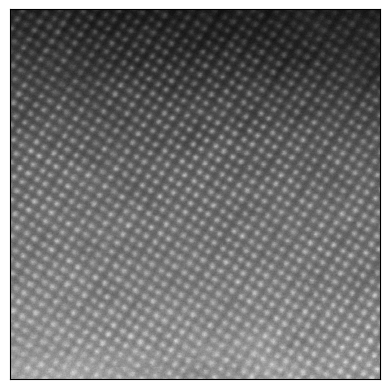

In [5]:
import SingleOrigin as so
from vpcffit.utils import select_files

img_path = str("./HZO_1323.dm3")

# Uncomment and run this line instead of the above if you want to load your own image:
# img_path = select_files()[0]

image = so.load_image(
    path = img_path, 
    display_image = True,
    return_path = True,
    images_from_stack = 'all'
)
#Make sure that the pixel size is in Angstroms  
pixel_size = image[1]['pixelSize'][0]*10
image=image[0]#[0:292,0:292]

In [6]:
from vpcffit.vpcffit import create_vpcfs_images
exp_vPCF = create_vpcfs_images((image,pixel_size), fit_atom_gaussian=True, method = 'gauss', blur_vpcf=5, separation=15, show_progressbar=True)

Center of mass:   0%|          | 0/1209 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/1209 [00:00<?, ?it/s]

Make sure you visualize the atomic column fitting by extracting the atomap lattice and plot the vPCF to make sure the peaks are correctly identify. You can modify the parameter (e.g. separation) to improve the fitting. Note that a few false positive or false negative atomic columns do not significantly affect the final result. Save the cartesian vPCF in a different variable.

Text(0.5, 1.0, 'vPCF')

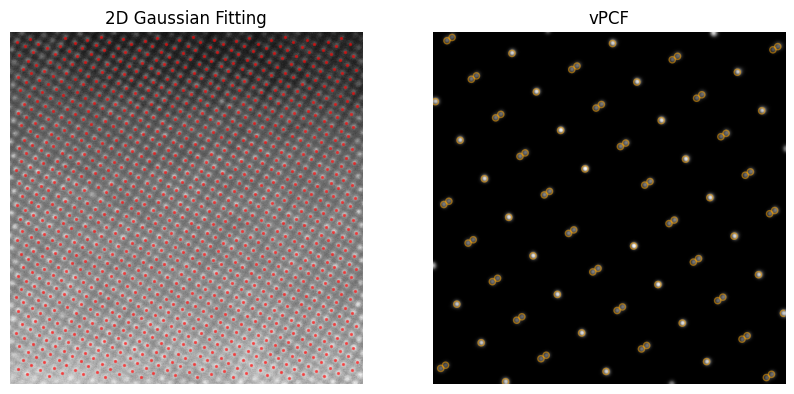

In [7]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

exp_vpcf = exp_vPCF[1]

# Create the GridSpec layout
fig = plt.figure(figsize=(10, 5))  # Set a suitable figure size
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)  # Create a 1-row, 2-column layout

# gaussian plot
ax1 = fig.add_subplot(gs[0])
ax1.scatter(exp_vPCF[2].x_position, exp_vPCF[2].y_position, c='red', s=2, alpha = 0.5)
ax1.imshow(-image, cmap ='Greys')
ax1.set_axis_off() 
ax1.set_title("2D Gaussian Fitting")

# vPCF plot
ax2 = fig.add_subplot(gs[1])
ax2.scatter(exp_vPCF[1][:,1]+exp_vPCF[0][1][1], exp_vPCF[1][:,0]+exp_vPCF[0][1][0], marker = 'o', s=20, edgecolor='orange', facecolor ='none', linewidth=1, alpha = 0.5)
im = ax2.imshow(-exp_vPCF[0][0], cmap ='Greys')
ax2.set_axis_off()
ax2.set_title("vPCF")
#plt.savefig(Path(img_path[0]).stem+'Gaussian_fitting_vPCF.png', dpi=300) 

## Matching experimental vPCFs
Let's now load a vPCF library. If you did not create the library, you need to create one, see "Nanoscale phase identification_vPCF" notebook for more information.

In [8]:
from vpcffit.utils import load_vpcfs

loaded_vpcfs = load_vpcfs()

Now we match the experimental vPCF with the lirbrary

In [9]:
target = exp_vpcf
#target[:,1] = -exp_vpcf[:,1] mirror symmetries are not yet included in the calculation, you would need to manually consider it to consider a mirror symmetry
limit = 515 # try to minimize the number of extra spots in the vPCF when matching. Experimental or theoretical vPCF can be calculated for larger r.
library_DB = loaded_vpcfs ## Select the database of vPCF as a library
library_pcs = list(library_DB.values())
keys=list(library_DB.keys())
bounds = [980,1020,5]

results = Parallel(n_jobs=-1)(delayed(parallel_process_pc)(pc, target, bounds, r_limit = limit,  nnd = 'ANND', mask_size =40, radial_pts= 200) for pc in library_pcs)

# Unpack results
tree_values, rotation, bs, sigma = [], [], [], []
for rotation_value, tree_value, best_scale, sigma_value, aligned_pc, compared_pc in results:
    rotation.append(rotation_value)
    tree_values.append(tree_value)
    bs.append(best_scale)
    sigma.append(sigma_value)

match_DB_exp = tree_values, rotation, bs, sigma

The results are saved in a variable called `match_DB_exp` and plotted in an interactive graph, where a bar plot indicates the ANND for each pair of vPCF (exp vs library). In this case, the polar plot corresponds to the best match in the library. If you click on one of the bars, the polar plot on the right is updated with the comparison of both vPCFs after alignment. The minimum value of the ANND is the best match in the library.  

The values on each bar represent the scaling required to better fit the experimental data to the simulated one. 

In [40]:
compare_exp_plot(match_DB_exp, target, keys, sigma = 3, save=False, mark_size=6)

    'data': [{'error_y': {'array': [1.1783542694615403, 1.03881780659,
         …

['Ortho-Pca21_100', 'Ortho-Pbca_001']

If you want to compare the images used for the vPCF library and the experimental image at the same time, you can load the simulated images dictionary and use the compare_exp_library_plot function instead of the compare_exp_plot. However, you have to have the simulated images saved. Let's load the images

In [16]:
import abtem
from pathlib import Path
from vpcffit.utils import create_zone_axes
from tqdm.notebook import tqdm
from vpcffit.vpcffit import supercell_axis_cif
import os
images = {}
models = {}
max_index = 2
zones={}
zone_num = 0# help plotting
file_list = [Path.cwd().parent/fname for fname in ["cif/Monoclinic.cif", "cif/Ortho-Pbca.cif", "cif/Ortho-Pca21.cif", "cif/Rhombo-R3.cif", "cif/Tetragonal.cif", "cif/Rhombo-R3m.cif"]]
for cif in file_list:
    zones[cif.stem]= create_zone_axes(max_index,cif)
for mapping in tqdm([(name, axes) for name in file_list for axes in zones[name.stem]],
                    desc="Loading refernce HAADF images", unit="image"):
    newkey = mapping[0].stem + "_" + str(mapping[1][0])+str(mapping[1][1])+str(mapping[1][2])    # Names of the form 'ciffilename_hkl'
    models[newkey]= supercell_axis_cif(mapping[0], mapping[1], size = 40)
    file_path=Path.cwd().parent/Path('simulations/'+newkey+"_HAADF.zarr")
    if not os.path.exists(file_path):
        print(f"⚠️ Warning: The path '{file_path}' does not exist!")
    #TODO: read the pixel size
    img = abtem.from_zarr(file_path).interpolate(sampling=0.1).gaussian_filter(0.5).array.compute()
    #add noise - You can skip the next two lines if you do not want to add noise
    #img = add_poisson_noise(img, px_size=0.01, dose=1e5)
    #img = add_scan_noise(img, shift_mag=3)
    images[newkey] = [img,0.1]

29 unique zone axes for space group: P 21/c
19 unique zone axes for space group: P b c a
33 unique zone axes for space group: P c a 21
36 unique zone axes for space group: R 3
12 unique zone axes for space group: P 42/n m c
27 unique zone axes for space group: R 3 m


Loading refernce HAADF images:   0%|          | 0/156 [00:00<?, ?image/s]

C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\zarr\creation.py:614: UserWarning:

ignoring keyword argument 'read_only'



In [17]:
best_match = compare_exp_library_plot(match_DB_exp, target, keys, images, models ,image, pixel_size, sigma = 1, save=False, mark_size=6, model = 'Nelder-Mead')

    'data': [{'colorscale': [[0.0, 'rgb(255,255,25…

Let's compared dynamical diffraction for the indistiguishable phases. For this we need to calculate the diffraction patterns for the best matches in the vPCF analysis and compare them with the FFT of the experimental image.

First let's calculate the dynamical diffraction using py4DSTEM. Note that the list of cif files need to exists. 

In [18]:
import py4DSTEM
import ase.io as aio

patterns_DB = {}
for cif in tqdm(file_list,
                    desc="Generating dynamical diffraction patterns", unit="Pattern"):
    phase = cif.stem
    for bestmatch in best_match:
        best = split_at_x_underscore(bestmatch, x = 1)
        if phase == best[0]:
            struct = aio.read(cif)
            kmax = 8
            beam_energy = 200e3
            thickness = 300
            za_idx = best[1]
            newkey = phase + "_" + za_idx
            
            #Kinematical calculation with forbiden reflections
            HfO = py4DSTEM.process.diffraction.crystal.Crystal.from_ase(struct)
            HfO.calculate_structure_factors(k_max = kmax, tol_structure_factor = 0)
            HfO.setup_diffraction(beam_energy)
            
            ZA = np.array((int(za_idx[0]),int(za_idx[1]),int(za_idx[2])))
            print(ZA)
            beams2 = HfO.generate_diffraction_pattern(
                zone_axis_lattice = ZA, 
                sigma_excitation_error = 0.03, #tolerance in units of sigma for s_g inclusion
                tol_intensity = 0.0002, #include forbide reflexions
                k_max = kmax,
            )
            
            #Dynamical calculation
            beams = HfO.generate_diffraction_pattern(
                zone_axis_lattice = ZA, 
                sigma_excitation_error = 0.03, #tolerance in units of sigma for s_g inclusion
                tol_intensity = 0.0002,
                k_max = kmax,
            )
            print (beams.data.shape)
            HfO.calculate_dynamical_structure_factors(
                beam_energy, 'WK-CP', k_max = kmax, thermal_sigma = 0.08, tol_structure_factor = 0.001)
            
            pattern = HfO.generate_dynamical_diffraction_pattern(
                beams = beams, 
                thickness =  thickness, 
                zone_axis_lattice = ZA, 
            )
            
            patterns_DB[newkey]=pattern

cupyx.jit.rawkernel is experimental. The interface can change in the future.


Generating dynamical diffraction patterns:   0%|          | 0/6 [00:00<?, ?Pattern/s]

This Atoms object contains occupancy information but it will be ignored.


[0 0 1]
(151,)


This Atoms object contains occupancy information but it will be ignored.


[1 0 0]
(135,)


Now let's plot the FFT of the image. For now, the FFT and the similated patterns need to be rotation manually. 

([], [])

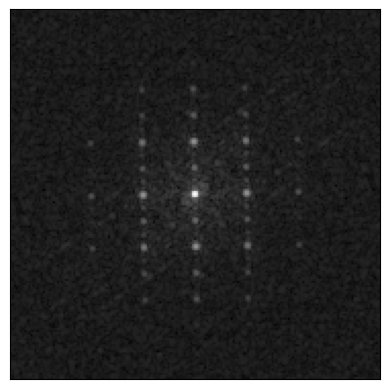

In [35]:
rot = 56.6
bin_factor = 4
imga = rotate(image,-rot, reshape=False)
crop_size = int(min(image.shape[0], image.shape[1]) / np.sqrt(2))
rotated_image = crop_at_position(imga,crop_size, crop_size, imga.shape[1]//2,imga.shape[0]//2)

binned_image = bin_image(rotated_image, bin_factor=bin_factor)
FFT = apply_fourier_transform(binned_image, hanning =True)
plt.imshow(FFT**(1/4), cmap = 'Greys_r')
plt.xticks([])
plt.yticks([])

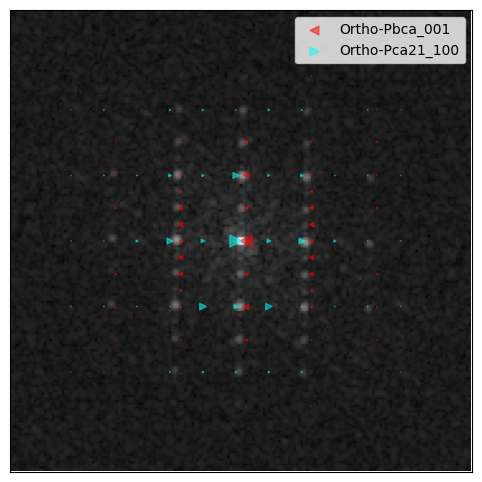

In [37]:
pixel_reciprocal = (1/pixel_size/FFT.shape[0])/bin_factor
k_max = 1
k_max_pixels = int(k_max/pixel_reciprocal)
center = (FFT.shape[0] // 2,FFT.shape[1] // 2)
scale = 1.0
shift_marker = 2
limit_plot = 1.4
intensity = 500

plt.figure(figsize=(10, 6))
plt.imshow(FFT**(1/4), cmap='Greys_r', alpha = 1.0)

simulated_diffraction = list(patterns_DB.values())[0]
simulated_diffraction = simulated_diffraction[(simulated_diffraction['qx']<k_max) & (simulated_diffraction['qx']>-k_max)]
simulated_diffraction = simulated_diffraction[(simulated_diffraction['qy']<k_max) & (simulated_diffraction['qy']>-k_max)]
_x = (simulated_diffraction['qx'])
_y = (simulated_diffraction['qy'])
angle = -0*np.pi/180
x = (_x*np.cos(angle)-_y*np.sin(angle))/pixel_reciprocal*scale+center[0]
y = (_x*np.sin(angle)+_y*np.cos(angle))/pixel_reciprocal*scale+center[1]
plt.scatter(x+shift_marker, y,
            s=simulated_diffraction['intensity']*intensity, color = 'red',#edgecolor='red', facecolor ='none', linewidth=1,
            label= list(patterns_DB.keys())[0], marker = "<", alpha = 0.5)

simulated_diffraction2 = list(patterns_DB.values())[1]
simulated_diffraction2 = simulated_diffraction2[(simulated_diffraction2['qx']<k_max) & (simulated_diffraction2['qx']>-k_max)]
simulated_diffraction2 = simulated_diffraction2[(simulated_diffraction2['qy']<k_max) & (simulated_diffraction2['qy']>-k_max)]
_x2 = (simulated_diffraction2['qx'])
_y2 = (simulated_diffraction2['qy'])
angle = -90*np.pi/180
x2 = (_x2*np.cos(angle)-_y2*np.sin(angle))/pixel_reciprocal*scale+center[0]
y2 = (_x2*np.sin(angle)+_y2*np.cos(angle))/pixel_reciprocal*scale+center[1]
plt.scatter(x2-shift_marker, y2,
            s=simulated_diffraction2['intensity']*intensity, color='cyan',# edgecolor='cyan', facecolor ='none', linewidth=1,
            label= list(patterns_DB.keys())[1], marker = ">", alpha = 0.5)

plt.xlim(-k_max_pixels*limit_plot+center[0],k_max_pixels*limit_plot+center[0])
plt.ylim(-k_max_pixels*limit_plot+center[1],k_max_pixels*limit_plot+center[1])
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()